# A basic set of tools for visualizing FESOM2.0 simulations

## Setting options

In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import standard python packages
import pickle
import sys
import time
import os

import numpy as np
from netCDF4 import Dataset
from tqdm import tqdm


sys.path.append('/p/project/chhb19/streffing1/software/pyfesom2')
#import pyfesom2 as pf
import seawater as sw

#from fesom_plot_tools import *
import cmocean.cm as cmo
import pyfesom2 as pf
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def load_mesh(path, abg=[0, 0, 0], usepickle=True, usejoblib=False, protocol=4):
    """Loads FESOM mesh

    Parameters
    ----------
    path : str
        Path to the directory with mesh files
    abg : list
        alpha, beta and gamma Euler angles. Rotated meshes use [50, 15, -90]
    usepickle: bool
        use pickle file to store or load mesh data
    usejoblib: bool
        use joblib file to store or load mesh data
    protocol: int
        used for pickle, only way to save data more than 4 Gb
    Returns
    -------
    mesh : object
        fesom_mesh object
    """
    path = os.path.abspath(path)
    if (usepickle == True) and (usejoblib == True):
        raise ValueError(
            "Both `usepickle` and `usejoblib` set to True, select only one"
        )

    CACHE_DIR = os.environ.get("PYFESOM_CACHE", os.path.join(os.getcwd(), "MESH_cache"))
    MESH_NAME = os.path.basename(path)
    CACHE_DIR = os.path.join(CACHE_DIR, MESH_NAME)
    if not os.path.isdir(CACHE_DIR):
        os.makedirs(CACHE_DIR)

    if usepickle:
        if os.path.isfile(os.path.join(path, "pickle_mesh_py3_fesom2")):
            pickle_file = os.path.join(path, "pickle_mesh_py3_fesom2")
            print(pickle_file)
        elif os.path.isfile(os.path.join(CACHE_DIR, "pickle_mesh_py3_fesom2")):
            pickle_file = os.path.join(CACHE_DIR, "pickle_mesh_py3_fesom2")
            print(pickle_file)
        else:
            pickle_file = "/dev/null"
            print(
                "pickle file not found in any default location, a try will be made to create it..."
            )

    if usejoblib:
        if os.path.isfile(os.path.join(path, "joblib_mesh_py3_fesom2")):
            joblib_file = os.path.join(path, "joblib_mesh_py3_fesom2")
            print(joblib_file)
        elif os.path.isfile(os.path.join(CACHE_DIR, "joblib_mesh_py3_fesom2")):
            joblib_file = os.path.join(CACHE_DIR, "joblib_mesh_py3_fesom2")
            print(joblib_file)
        else:
            joblib_file = "/dev/null"  # Use a string here, the check below needs it
            print(
                "joblib file not found in any default location, a try will be made to create it..."
            )

    if usepickle and (os.path.isfile(pickle_file)):
        print("The usepickle == True)")
        print("The pickle file for FESOM2 exists.")
        print("The mesh will be loaded from {}".format(pickle_file))

        ifile = open(pickle_file, "rb")
        mesh = pickle.load(ifile)
        ifile.close()
        return mesh

    elif (usepickle == True) and (os.path.isfile(pickle_file) == False):
        print("The usepickle == True")
        print("The pickle file for FESOM2 DO NOT exists")

        mesh = fesom_mesh(path=path, abg=abg)

        try:  # to save in the mesh first...
            pickle_file = os.path.join(path, "pickle_mesh_py3_fesom2")
            print("The mesh will be saved to {}".format(pickle_file))
            logging.info("Use pickle to save the mesh information")
            print("Save mesh to binary format")
            outfile = open(pickle_file, "wb")
            pickle.dump(mesh, outfile, protocol=protocol)
            outfile.close()
        except PermissionError:
            try:  # to save in the cache next...
                pickle_file = os.path.join(CACHE_DIR, "pickle_mesh_py3_fesom2")
                print("The mesh will be saved to {}".format(pickle_file))
                logging.info("Use pickle to save the mesh information")
                print("Save mesh to binary format")
                outfile = open(pickle_file, "wb")
                pickle.dump(mesh, outfile, protocol=protocol)
                outfile.close()
            except PermissionError:  # couldn't save in either location...
                print("Something went wrong with saving the pickle, sorry...")
        return mesh

    elif (usepickle == False) and (usejoblib == False):
        mesh = fesom_mesh(path=path, abg=abg)
        return mesh

    if (usejoblib == True) and (os.path.isfile(joblib_file)):
        print("The usejoblib == True)")
        print("The joblib file for FESOM2 exists.")
        print("The mesh will be loaded from {}".format(joblib_file))

        mesh = joblib.load(joblib_file)
        return mesh

    elif (usejoblib == True) and (os.path.isfile(joblib_file) == False):
        print("The usejoblib == True")
        print("The joblib file for FESOM2 DO NOT exists")

        mesh = fesom_mesh(path=path, abg=abg)

        try:  # to save in the mesh first...
            joblib_file = os.path.join(path, "joblib_mesh_py3_fesom2")
            print("The mesh will be saved to {}".format(joblib_file))
            logging.info("Use joblib to save the mesh information")
            print("Save mesh to binary format")
            outfile = open(joblib_file, "wb")
            joblib.dump(mesh, outfile, protocol=protocol)
            outfile.close()
        except PermissionError:
            try:  # to save in the cache next...
                joblib_file = os.path.join(CACHE_DIR, "joblib_mesh_py3_fesom2")
                print("The mesh will be saved to {}".format(joblib_file))
                logging.info("Use joblib to save the mesh information")
                print("Save mesh to binary format")
                outfile = open(joblib_file, "wb")
                joblib.dump(mesh, outfile, protocol=protocol)
                outfile.close()
            except PermissionError:  # couldn't save in either location...
                print("Something went wrong with saving the joblib, sorry...")
        return mesh

## read the mesh

In [46]:
# set the path to the mesh
mesh_name = 'LR'

if mesh_name == 'LR':
    meshpath  ='/home/jstreffi/thesis/data/'
    area_file ='/home/jstreffi/thesis/data/CORE2_finaltopo_mean.nc'
    alpha, beta, gamma=[0, 0, 0]
    mesh_n_points = 126858
elif mesh_name == 'MR':
    meshpath  ='/work/ollie/jstreffi/input/fesom2/MR/'
    alpha, beta, gamma=[0, 0, 0]
    mesh_n_points = 830305
elif mesh_name == 'HR':
    meshpath  ='/work/ollie/jstreffi/input/fesom2/HR/'
    alpha, beta, gamma=[0, 0, 0]
    mesh_n_points = 1306775

mesh = load_mesh(meshpath)  
mesh

/home/jstreffi/thesis/data/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /home/jstreffi/thesis/data/pickle_mesh_py3_fesom2



FESOM mesh:
path                  = /home/jstreffi/thesis/data
alpha, beta, gamma    = 0, 0, 0
number of 2d nodes    = 126858
number of 2d elements = 244659

        

In [47]:
from mpl_toolkits.basemap import Basemap
def ftriplot(
    mesh,
    data2,
    contours,
    cmap=[],
    proj="global",
    do_cbar=True,
    mlabels=[0, 0, 0, 0],
    plabels=[0, 0, 0, 0],
    boundinglat=50,
    lon_0=0,
    extend='both',
    data_on_elem=0,
):
        data2 = np.copy(data2)
        elem2 = mesh.elem  # [mesh.no_cyclic_elem,:]
        d = data2[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2 = elem2[k, :]
        print("ftriplot, number of dummy points:", len(d) - len(k))
        map = Basemap(projection=proj, boundinglat=boundinglat, lon_0=lon_0, resolution="l")
        x, y = map(mesh.x2, mesh.y2)
        map.drawcoastlines()
        map.drawparallels(np.arange(-80.0, 81.0, 20.0), labels=plabels)
        map.drawmeridians(np.arange(-180.0, 181.0, 20.0), labels=mlabels)  # [0,1,0,0]
        map.drawmapboundary(fill_color="0.9")
        map.fillcontinents(color=".7", lake_color=".7")
        print(np.shape(x))
        print(np.shape(y))
        print(np.shape(elem2))
        print(np.shape(data2))
        
        im = plt.tricontourf(
            x, y, elem2, data2, levels=contours, cmap=cmap, extend=extend
        )
        if do_cbar:
            cbar = map.colorbar(im, "bottom", size="5%", pad="2%")

        return (im, map, cbar if (do_cbar) else False)


def read_fesom_slice(str_id, records, year, mesh, result_path, runid, ilev=0, how='mean', verbose=False, ncfile=''):
        #print(['reading year '+str(year)+':'])
    if (ncfile==''):
        ncfile =result_path+'/'+str_id+'.'+runid+'.'+str(year)+'.nc'
    if (verbose):
        print(['reading ', ncfile])
    f = Dataset(ncfile, 'r')
    # dimensions of the netcdf variable
    ncdims=f.variables[str_id].shape
    # indexies for reading 2D part
    if (verbose):
        if (ncdims[1]==mesh.n2d):
            print('data at nodes')
        elif (ncdims[1]==mesh.e2d):
            print('data on elements')
        else:
            raise IOError('not existing dimension '+str(ncdims[1]))

    dim=[records, np.arange(ncdims[1])]
    data=np.zeros(shape=(ncdims[1]))
    # add 3rd index if reading a slice from 3D data
    if (len(ncdims)==3):
       dim.append(ilev)

    if how=='mean':
       data = data+f.variables[str_id][dim].mean(axis=0)
    elif how=='max':
        data = data+f.variables[str_id][dim].max(axis=0)
    elif how=='min':
        data = data+f.variables[str_id][dim].min(axis=0)
    f.close()
    return data

def ind_for_depth(depth, mesh):
    '''
    Find the model depth index that is closest to the required depth
    
    Parameters
    ----------
    depth : float
        desired depth. 
    mesh : object
        FESOM mesh object

    Returns
    dind : int
        index that corresponds to the model depth level closest to `depth`.
    -------
    '''
    arr=([abs(abs(z)-abs(depth)) for z in mesh.zlev])
    v, i= min((v, i) for (i, v) in enumerate(arr))
    dind=i
    return dind

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Sea ice thickness
### Northern Hemisphere

  0%|                                                                              | 0/24 [00:00<?, ?it/s]/home/jstreffi/miniconda3/envs/dev/lib/python3.10/site-packages/netCDF4/utils.py:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([_is_int(e) for e in elem]).all()):
100%|█████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 69.47it/s]


ftriplot, number of dummy points: 177527
(126858,)
(126858,)
(67132, 3)
(126858,)
ftriplot, number of dummy points: 237736
(126858,)
(126858,)
(6923, 3)
(126858,)


  0%|                                                                              | 0/24 [00:00<?, ?it/s]/home/jstreffi/miniconda3/envs/dev/lib/python3.10/site-packages/netCDF4/utils.py:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([_is_int(e) for e in elem]).all()):
100%|█████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 85.69it/s]


ftriplot, number of dummy points: 188367
(126858,)
(126858,)
(56292, 3)
(126858,)
ftriplot, number of dummy points: 219136
(126858,)
(126858,)
(25523, 3)
(126858,)


  0%|                                                                              | 0/24 [00:00<?, ?it/s]/home/jstreffi/miniconda3/envs/dev/lib/python3.10/site-packages/netCDF4/utils.py:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([_is_int(e) for e in elem]).all()):
100%|█████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 76.70it/s]


ftriplot, number of dummy points: 237736
(126858,)
(126858,)
(6923, 3)
(126858,)


  0%|                                                                              | 0/24 [00:00<?, ?it/s]/home/jstreffi/miniconda3/envs/dev/lib/python3.10/site-packages/netCDF4/utils.py:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([_is_int(e) for e in elem]).all()):
100%|█████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 86.54it/s]


ftriplot, number of dummy points: 219136
(126858,)
(126858,)
(25523, 3)
(126858,)


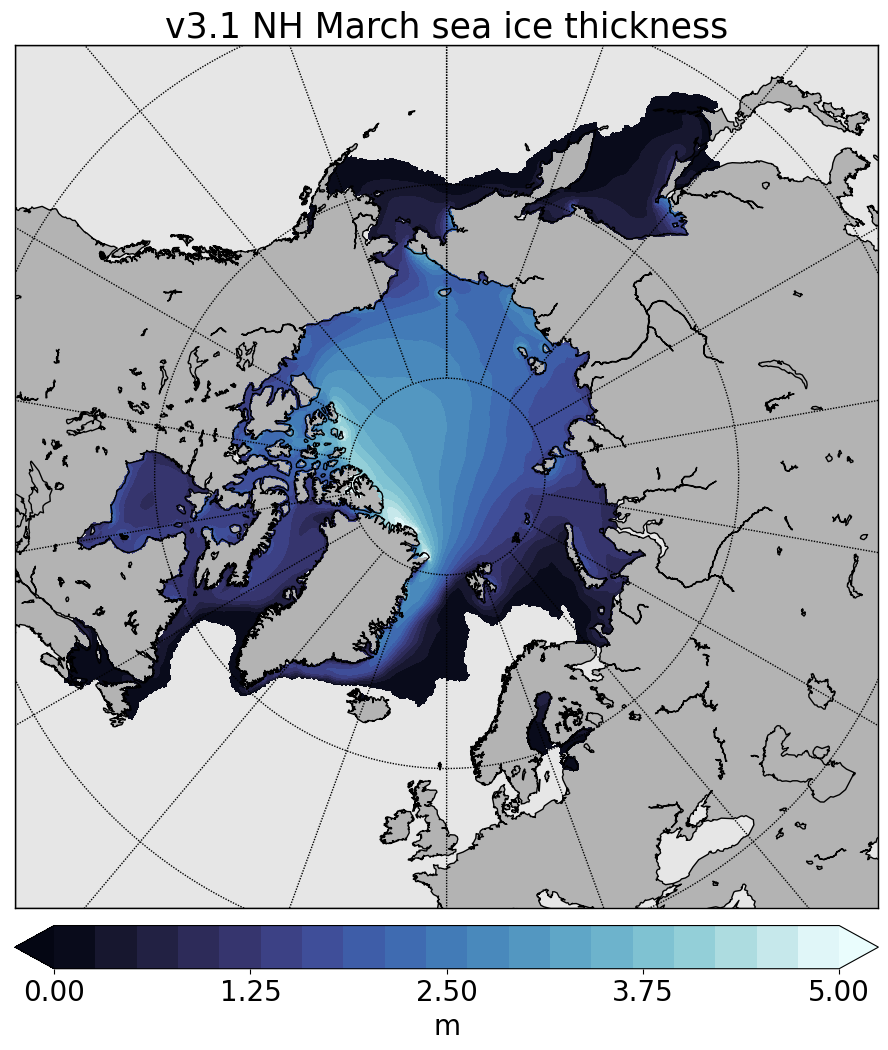

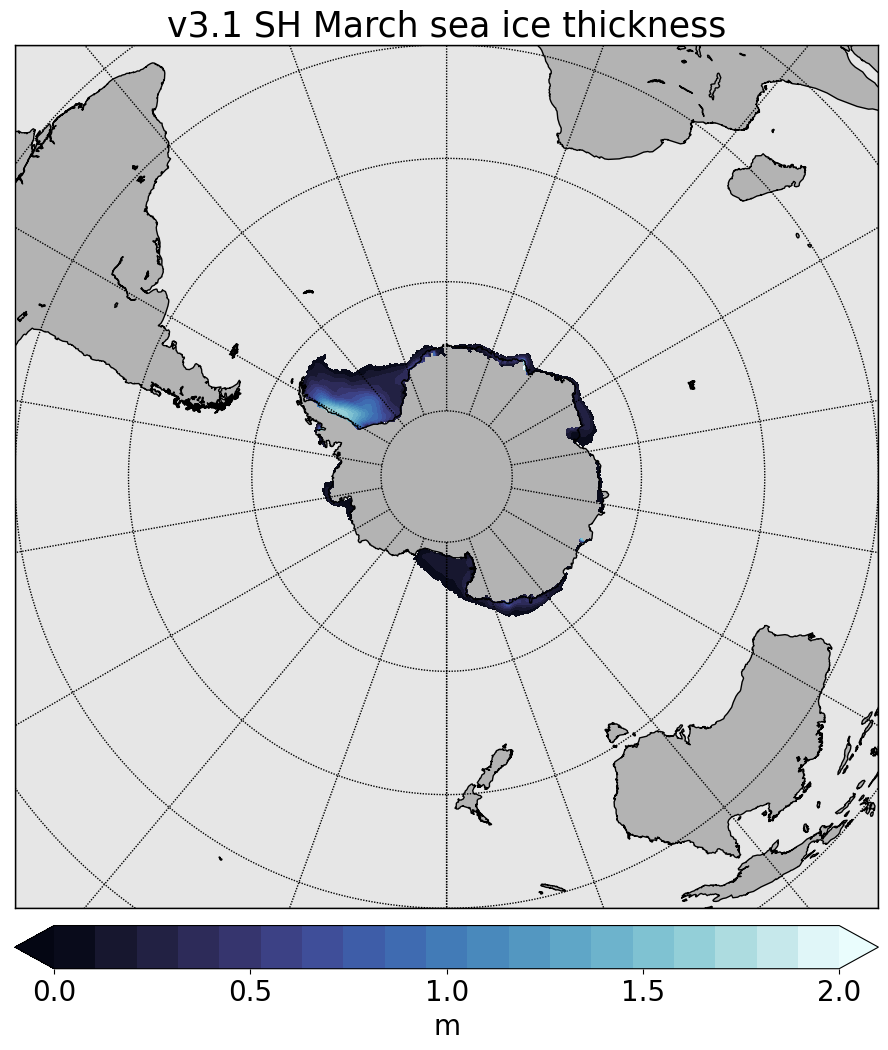

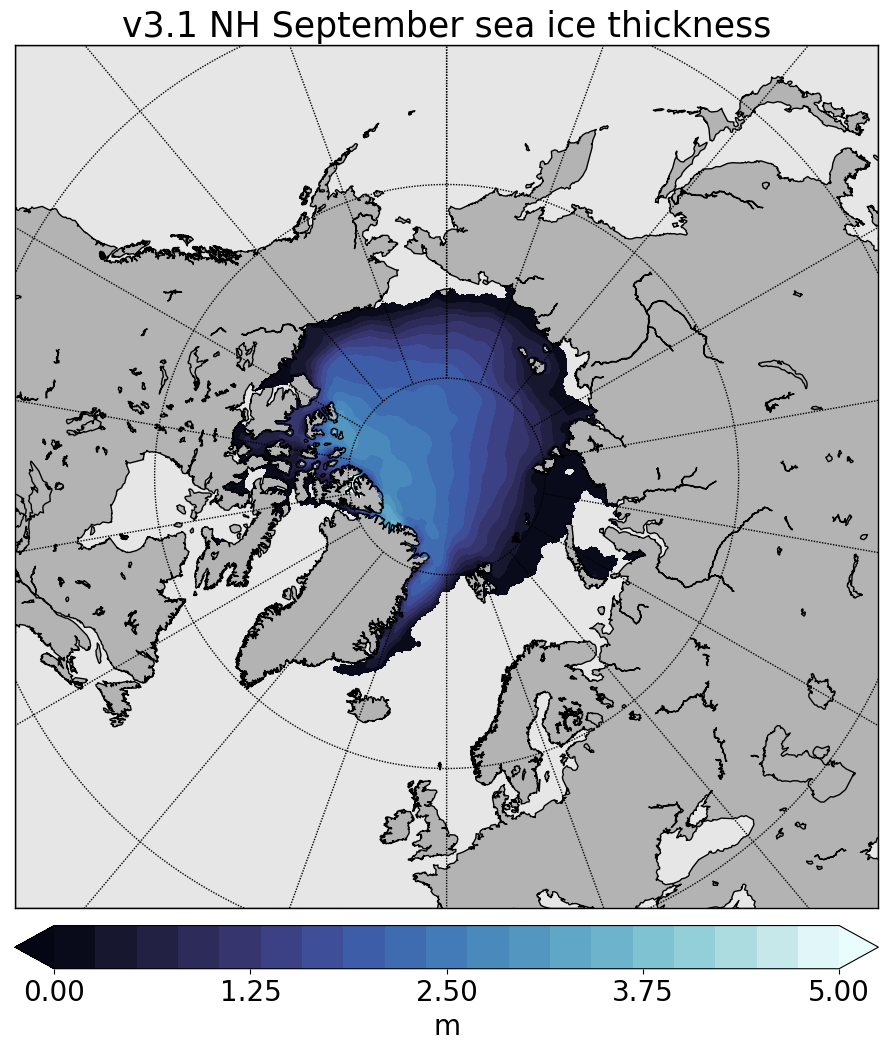

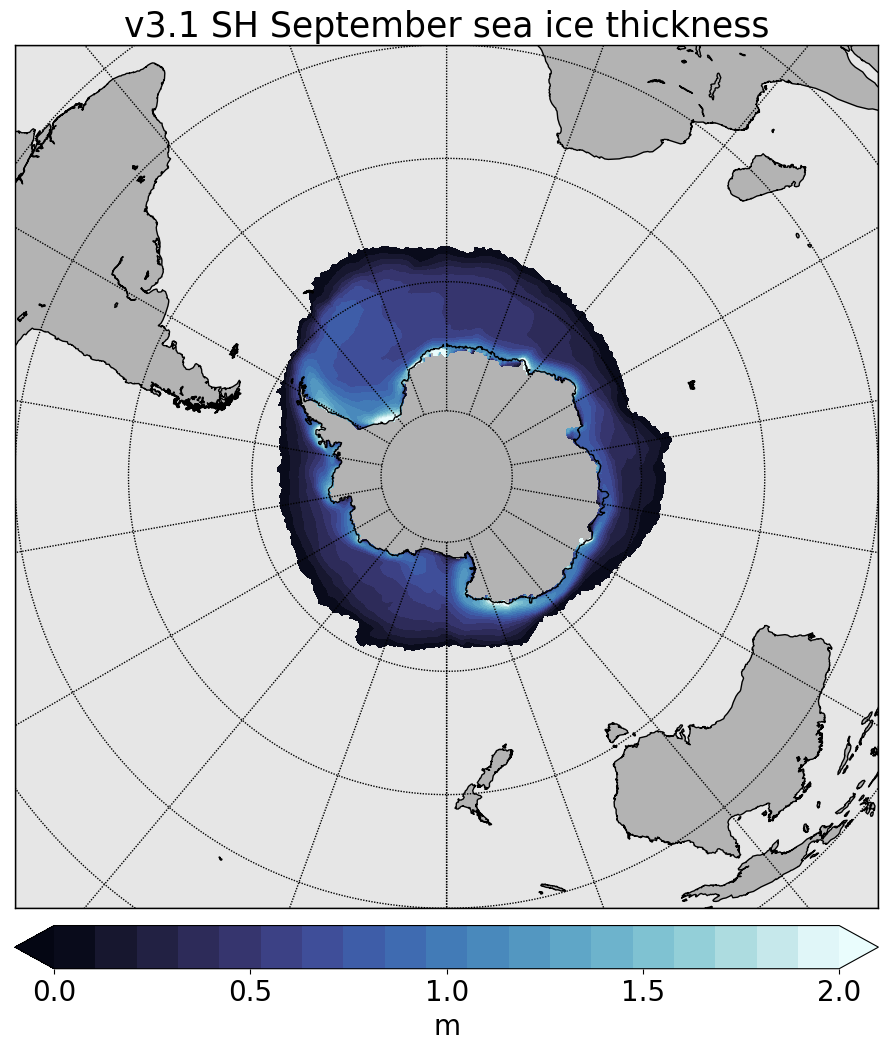

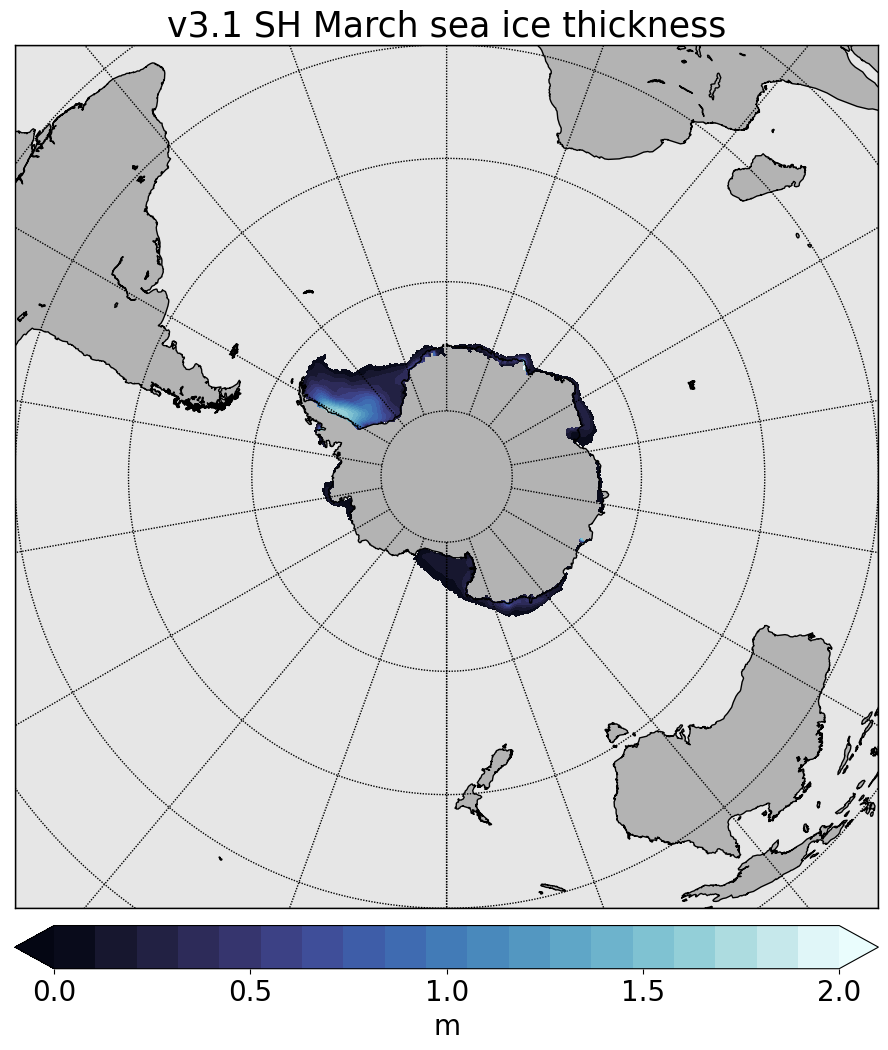

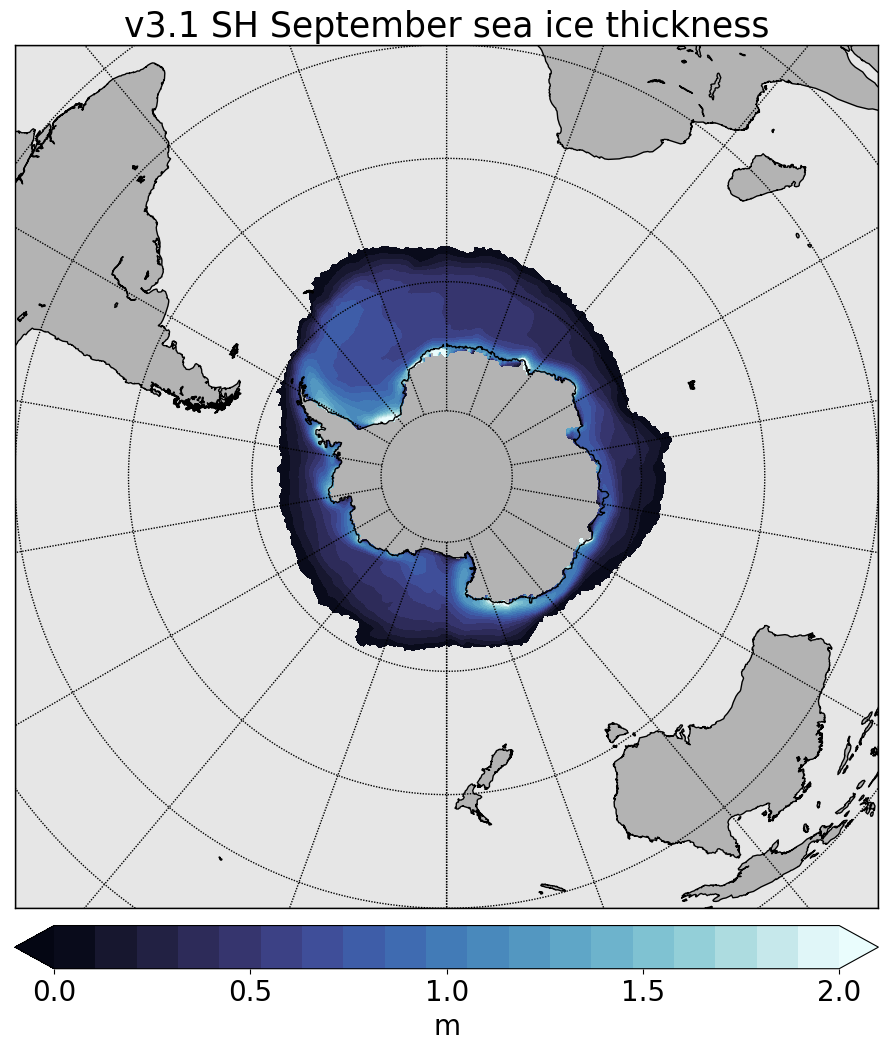

In [49]:
# set the paths to the results, runid, etc.

for exp in ['v3.1']:

    result_path ='/home/jstreffi/thesis/data/v3.1/'
    year_start = 1990
    year_end = 2014
        
    runid ='fesom'
    str_id='m_ice'
    cor_id='a_ice'
    
    for season in [2,8]:
        if season == 2:
            name_season = 'March'
        elif season == 8:
            name_season = 'September'
            
        # specify depth, records and year to read
        depth, records, year_start, year_end=0, np.linspace(season,season,1).astype(int), year_start, year_end
        # get the closest model deprecordsth to the desired one
        data_total = [0 for x in range(mesh_n_points)]
        conc_total = [0 for x in range(mesh_n_points)]


        # read the model result from str_id.XXXX.nc
        for y in tqdm(range(year_start, year_end)): 
            data=read_fesom_slice(str_id, records, y, mesh, result_path, runid, ilev=0)
            data_total = data_total + data
            conc=read_fesom_slice(cor_id, records, y, mesh, result_path, runid, ilev=0)
            conc_total = conc_total +conc
        data_avg = data_total/len(range(year_start, year_end))
        conc_avg = conc_total/len(range(year_start, year_end))

        # choose the colorbar and plot the data
        cmap=cmo.ice
            
        for hemi in ['NH','SH']:
            if hemi == 'SH':
                proj='splaea'
                cbartext, cont = 'm', [-0., 2, .1]
                boundinglat=-20
                lon_0=180
            elif hemi == 'NH':
                proj='nplaea'
                cbartext, cont = 'm', [-0., 5, .25]
                boundinglat=45
                lon_0=0
                

            fig =plt.figure(figsize=(12,12))

            # remove areas where mean thickness is very low
            data_avg = data_avg #/ conc_avg
            data_avg[conc_avg<0.05]=np.nan

            if hemi == 'SH':
                data_avg[mesh.y2>0]=np.nan
                
            [im, map, cbar]=ftriplot(mesh, data_avg, np.linspace(cont[0], cont[1], 20), proj=proj, boundinglat=boundinglat, lon_0=lon_0, cmap=cmap)
            cbar.set_label(cbartext, fontsize=20)
            cbar.set_ticks([round(i,7) for i in np.linspace(cont[0], cont[1], 5)])
            cbar.ax.tick_params(labelsize=20)
            plt.title(exp+ " "+hemi+" "+name_season+" sea ice thickness", fontsize=25)

            plt.savefig(exp+ "_"+name_season+"_"+hemi+"_sea_ice_thickness.png",dpi=300,bbox_inches='tight')
            
            
# set the paths to the results, runid, etc.

for exp in ['v3.1']:

    result_path ='/home/jstreffi/thesis/data/v3.1/'
    year_start = 1990
    year_end = 2014
        
    runid ='fesom'
    str_id='m_ice'
    cor_id='a_ice'
    
    for season in [2,8]:
        if season == 2:
            name_season = 'March'
        elif season == 8:
            name_season = 'September'
            
        # specify depth, records and year to read
        depth, records, year_start, year_end=0, np.linspace(season,season,1).astype(int), year_start, year_end
        # get the closest model deprecordsth to the desired one
        data_total = [0 for x in range(mesh_n_points)]
        conc_total = [0 for x in range(mesh_n_points)]


        # read the model result from str_id.XXXX.nc
        for y in tqdm(range(year_start, year_end)): 
            data=read_fesom_slice(str_id, records, y, mesh, result_path, runid, ilev=0)
            data_total = data_total + data
            conc=read_fesom_slice(cor_id, records, y, mesh, result_path, runid, ilev=0)
            conc_total = conc_total +conc
        data_avg = data_total/len(range(year_start, year_end))
        conc_avg = conc_total/len(range(year_start, year_end))

        # choose the colorbar and plot the data
        cmap=cmo.ice
            
        for hemi in ['SH']:
            if hemi == 'SH':
                proj='splaea'
                cbartext, cont = 'm', [-0., 2, .2]
                boundinglat=-20
                lon_0=180
            elif hemi == 'NH':
                proj='nplaea'
                cbartext, cont = 'm', [-0., 5, .5]
                boundinglat=45
                lon_0=0
                

            fig =plt.figure(figsize=(12,12))

            # remove areas where mean thickness is very low
            data_avg = data_avg #/ conc_avg
            data_avg[conc_avg<0.05]=np.nan

            if hemi == 'SH':
                data_avg[mesh.y2>0]=np.nan
                
            [im, map, cbar]=ftriplot(mesh, data_avg, np.linspace(cont[0], cont[1], 20), proj=proj, boundinglat=boundinglat, lon_0=lon_0, cmap=cmap)
            cbar.set_label(cbartext, fontsize=20)
            cbar.set_ticks([round(i,7) for i in np.linspace(cont[0], cont[1], 5)])
            cbar.ax.tick_params(labelsize=20)
            plt.title(exp+ " "+hemi+" "+name_season+" sea ice thickness", fontsize=25)

            plt.savefig(exp+ "_"+name_season+"_"+hemi+"_sea_ice_thickness.png",dpi=300,bbox_inches='tight')

/tmp/ipykernel_109381/1410848720.py:62: UserWarning: The following kwargs were not used by contour: 'tri'
  im = map.contourf(
/tmp/ipykernel_109381/1410848720.py:62: UserWarning: The following kwargs were not used by contour: 'tri'
  im = map.contourf(


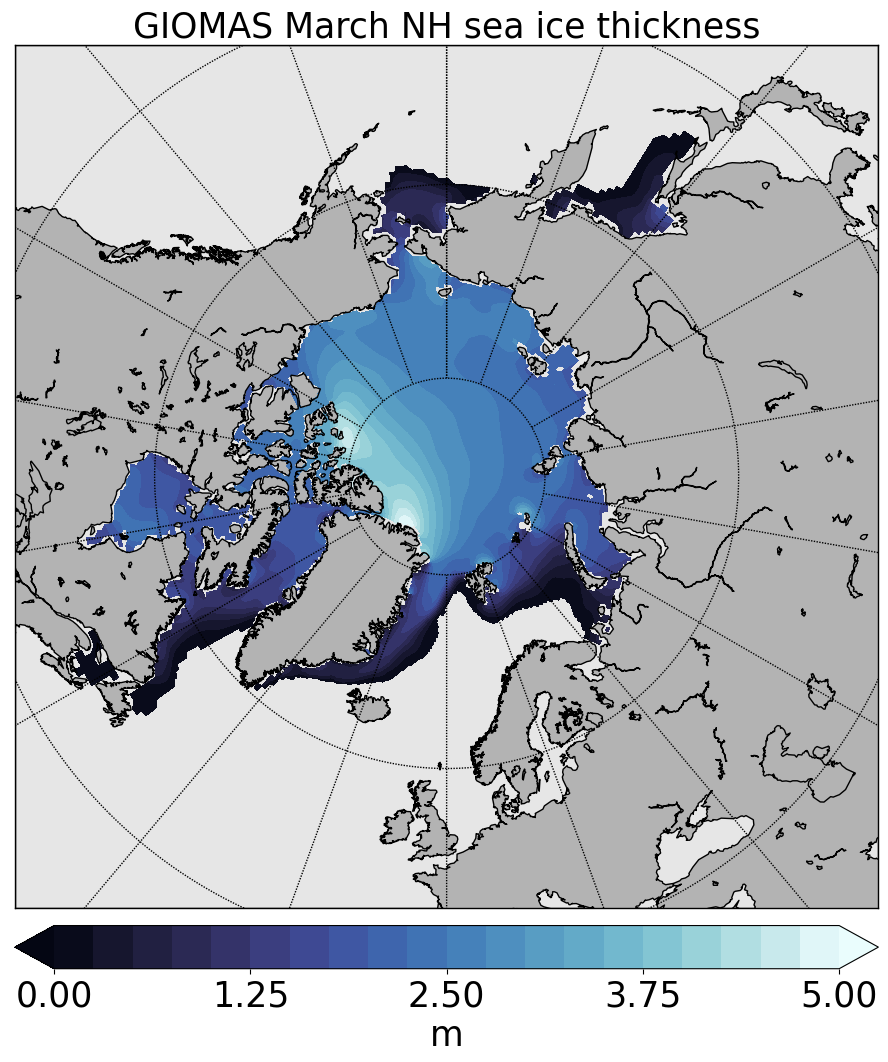

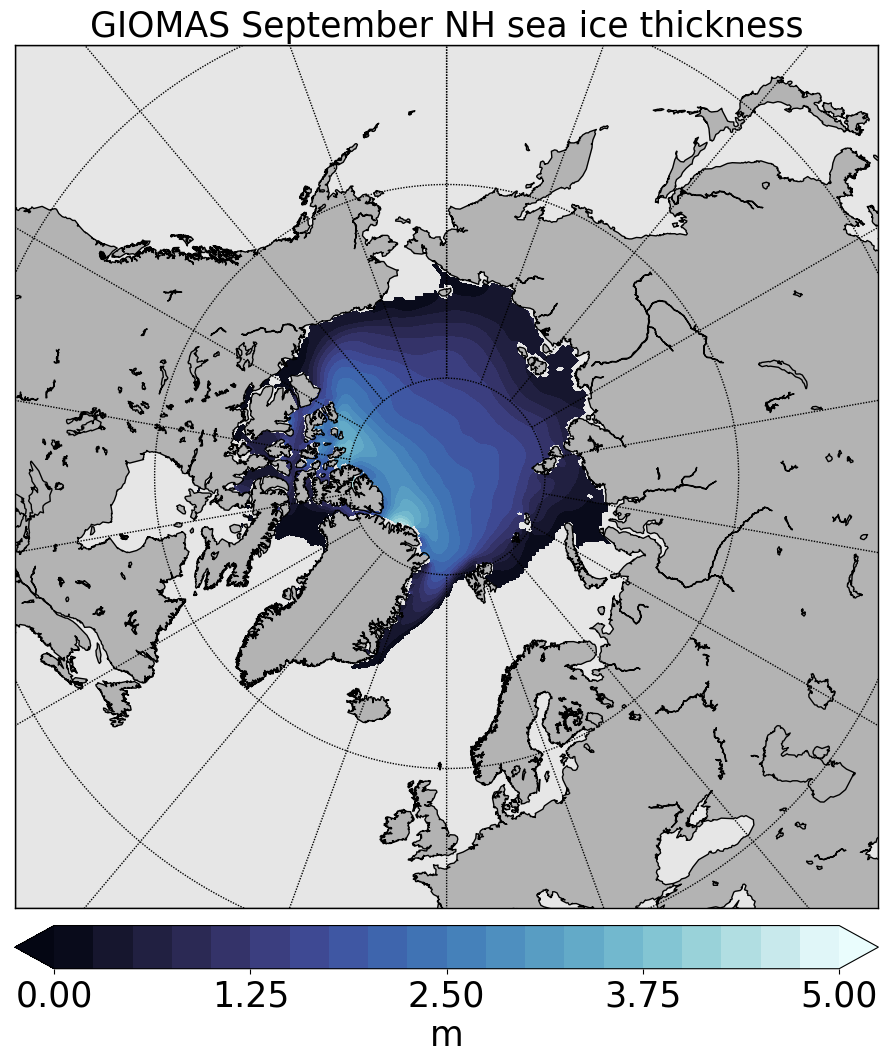

In [42]:
# Plot GIOMAS
#cmap = cmo.ice
import cmocean as cmo

extend='both'

# Load model data
import xarray as xr
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

for exp in ['GIOMAS']:
    path ='/home/jstreffi/thesis/data/GIOMAS_heff_miss_time_mon.nc'
    if exp == 'GIOMAS':
        var = 'heff'
        year_start = 1990
        year_end = 2008
        
# Load model Data
data = OrderedDict()
paths = []

intermediate = []
intermediate = xr.open_mfdataset(path, combine="by_coords", engine="netcdf4", use_cftime=True)
data[var] = intermediate.compute()
data2=data[var]

x = np.asarray(data2.lon_scaler).flatten()
y = np.asarray(data2.lat_scaler).flatten()

for name_season in ['March','September']:
    if name_season == 'March':
        month=3
    elif name_season == 'September':
        month=9
    heff = np.asarray(data2.heff.fillna(0)[month,:,:]).flatten()
    heff = np.ma.array(heff, mask=heff < 0.05)
    for hemi in ['NH']:

        # Format for contourf
        fig =plt.figure(figsize=(12,12))
        
        # Defaults
        do_cbar=True,
        mlabels=[0, 0, 0, 0]
        plabels=[0, 0, 0, 0]
        extend='both'
        data_on_elem=0

        if hemi == "NH":
            cont=[0,5]
            contours=np.linspace(cont[0], cont[1], 21)
            map = Basemap(projection="nplaea", boundinglat=45, lon_0=0, resolution="l")
            map.drawcoastlines()
            map.drawparallels(np.arange(-80.0, 81.0, 20.0), labels=plabels)
            map.drawmeridians(np.arange(-180.0, 181.0, 20.0), labels=mlabels)  # [0,1,0,0]
            map.drawmapboundary(fill_color="0.9")
            map.fillcontinents(color=".7", lake_color=".7")
            im = map.contourf(
                x, y, heff, tri=True, latlon=True, levels=contours, cmap=cmo.cm.ice, extend=extend
            )

            if do_cbar:
                cbar = map.colorbar(im, "bottom", size="5%", pad="2%")
        elif hemi == "SH":
            cont=[0,2]
            contours=np.linspace(cont[0], cont[1], 21)
            map = Basemap(projection="splaea", boundinglat=-20, lon_0=180, resolution="l")
            map.drawcoastlines()
            map.drawparallels(np.arange(-80.0, 81.0, 20.0), labels=plabels)
            map.drawmeridians(np.arange(-180.0, 181.0, 20.0), labels=mlabels)  # [0,1,0,0]
            map.drawmapboundary(fill_color="0.9")
            map.fillcontinents(color=".7", lake_color=".7")
            im = map.contourf(
                x, y, heff, tri=True, latlon=True, levels=contours, cmap=cmo.cm.ice, extend=extend
            )

            if do_cbar:
                cbar = map.colorbar(im, "bottom", size="5%", pad="2%")
        cbar.set_label(cbartext, fontsize=25)
        cbar.set_ticks([round(i,7) for i in np.linspace(cont[0], cont[1], 5)])
        cbar.ax.tick_params(labelsize=25)
        plt.title(exp+ " "+name_season+" "+hemi+" sea ice thickness", fontsize=25)

        plt.savefig(exp+ "_"+name_season+"_"+hemi+"_sea_ice_thickness.png",dpi=300,bbox_inches='tight')
